<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/lstm_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

TPU has a different way of downloading dependencies keep the cell below to avoid dependency conflicts

In [3]:
!pip install -qqqq mlflow torchmetrics pytorch_lightning

In [4]:
import mlflow

In [5]:
memmap_meta_path = "src/data/memmap/memmap_meta.npz"
memmap_path = "src/data/memmap/memmap.npy"
df_diag_path = "src/data/records_w_diag_icd10.csv"
df_memmap_pkl_path = "src/data/memmap/df_memmap.pkl"


# Merge dataset with labels and ecg paths

In [6]:
import pandas as pd

df_diag = pd.read_csv(df_diag_path)
df_mapped = pd.read_pickle(df_memmap_pkl_path)

In [7]:
df_diag['label_test']

,label_test
0,[]
1,[]
2,[]
3,[]
4,[]
...,...
800030,[]
800031,[]
800032,[]
800033,[np.str_('I61')]


In [8]:
# merged_df = pd.merge(df_pkl, df_mapped, on=["study_id"], how="left")

# Labeling stroke classes

In [9]:
df_labels = df_diag['label_test'].apply(lambda x: 0 if x == '[]' else 1).to_frame(name='Stroke_YN')

# Visualizing target class distribution

In [10]:
# Count the occurrences of each target class
target_counts = df_labels['Stroke_YN'].value_counts()
print(target_counts)

Stroke_YN
0    782005
1     18030
Name: count, dtype: int64


<ipython-input-11-33e75e129976>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


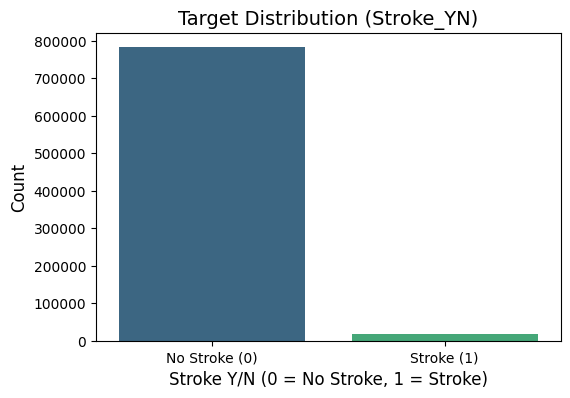

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Distribution (Stroke_YN)", fontsize=14)
plt.xlabel("Stroke Y/N (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], labels=["No Stroke (0)", "Stroke (1)"])
plt.show()

# Data Class

In [45]:
import torch
from torch.utils.data import Dataset

class ECGDataset(Dataset):
    def __init__(self, memmap, starts, lengths, labels_df):
        self.df = labels_df
        self.memmap = memmap
        self.starts = starts
        self.lengths = lengths

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
            # Access data directly from the DataFrame
            start = self.df.loc[idx, 'start']
            length = self.df.loc[idx, 'length']
            # file_idx = self.df.loc[idx, 'file_idx'] # You might not need file_idx here anymore

            # Extract the flat signal slice
            signal = self.memmap[start : start + length * 12]  # 12 features per timestep
            signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)

            # Reshape to [length, 12]
            signal = signal.reshape(length, 12)

            # Convert signal to PyTorch tensor before checking for NaN/inf
            signal = torch.tensor(signal, dtype=torch.float32)

            if torch.isnan(signal).any() or torch.isinf(signal).any():
              print(f"Warning: NaN or infinite values found in sample {idx}")
              # Handle appropriately (e.g., replace with mean, discard sample)


            label = self.df.loc[idx, 'Stroke_YN']  # Access label from DataFrame
            return signal, torch.tensor(label, dtype=torch.long) # signal is already a tensor


In [46]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class ECGDataModule(pl.LightningDataModule):
    def __init__(self, memmap, starts, lengths, train_df, val_df, test_df, batch_size=32):
        super().__init__()
        self.memmap = memmap
        self.starts = starts
        self.lengths = lengths
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = ECGDataset(self.memmap, self.starts, self.lengths, self.train_df)
        self.val_dataset = ECGDataset(self.memmap, self.starts, self.lengths, self.val_df)
        self.test_dataset = ECGDataset(self.memmap, self.starts, self.lengths, self.test_df)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=11)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


# Simple LSTM Model

In [40]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torchmetrics.classification import BinaryF1Score, BinaryAUROC


class LSTMSleepClassifier(pl.LightningModule):
    def __init__(self, input_size=12, hidden_size=64, num_layers=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()

        self.train_auc = BinaryAUROC()
        self.val_auc = BinaryAUROC()
        self.test_auc = BinaryAUROC()

        self.fc = nn.Linear(hidden_size * 2, 1)  # bidirectional
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        # x: (B, T, C) → needs to be (B, T, 12)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        logits = self.fc(out)
        return logits.squeeze()

    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y).float().mean()
        f1 = self.train_f1(preds, y)
        auc = self.train_auc(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.log("train_f1", f1, prog_bar=True)
        self.log("train_auc", auc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5

        acc = (preds == y).float().mean()
        f1 = self.val_f1(preds, y)
        auc = self.val_auc(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_auc", auc, prog_bar=True)

        return loss


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits) > 0.5

        acc = (preds == y).float().mean()
        f1 = self.test_f1(preds, y)
        auc = self.test_auc(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_auc", auc, prog_bar=True)

        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)  # Reduced lr


# Data Sampling

In [15]:
import pandas as pd
import numpy as np

# Load metadata
meta = np.load(memmap_meta_path, allow_pickle=True)
start = meta["start"]
length = meta["length"]
file_idx = meta["file_idx"]
filenames = meta["filenames"]

# Load labels CSV
df = df_labels.copy()

# Sanity check
assert len(df) == len(start), "Mismatch between label and memmap metadata length"

# Add metadata into DataFrame
df['start'] = start
df['length'] = length
df['file_idx'] = file_idx

# Now you can split the DataFrame while keeping track of ECG data pointers
from sklearn.model_selection import train_test_split

# Split test set with preserved stroke ratio
train_val_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df['Stroke_YN'], random_state=42
)

# Then split stroke/non-stroke from train_val_df as discussed before
stroke_df = train_val_df[train_val_df['Stroke_YN'] == 1]
nonstroke_df = train_val_df[train_val_df['Stroke_YN'] == 0]

# Balanced sampling
train_stroke, val_stroke = train_test_split(stroke_df, test_size=0.1, random_state=42)
train_nonstroke = nonstroke_df.sample(n=len(train_stroke)*2, random_state=42)
val_nonstroke = nonstroke_df.drop(train_nonstroke.index).sample(n=len(val_stroke)*2, random_state=42)

# Final splits
train_df = pd.concat([train_stroke, train_nonstroke]).reset_index(drop=True)
val_df = pd.concat([val_stroke, val_nonstroke]).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


Model and data Initialization

In [28]:
memmap_data = np.memmap(memmap_path, dtype=np.float32, mode='r')
# memmap_data = torch.tensor(memmap_data).to("cuda")
meta = np.load(memmap_meta_path, allow_pickle=True)
starts = meta['start']
lengths = meta['length']

In [47]:
# Create the data module
ecg_dm = ECGDataModule(
    memmap=memmap_data,
    starts=starts,
    lengths=lengths,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=64
)

In [42]:
# Initialize model
model = LSTMSleepClassifier(input_size=12)

# Setting up Mlflow for model baseline tracking

# Model Training

In [19]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
import mlflow

import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = "Zfeng0207"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "af7c8365aec4d3ff7a40563a35ec94d4bc9b4512"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "stroke-prediction-dagshub-repo"
# Setup
experiment_name = "ecg-lstm-experiment"
tracking_uri = f"https://dagshub.com/{os.environ['MLFLOW_TRACKING_USERNAME']}/{os.environ['MLFLOW_TRACKING_PROJECTNAME']}.mlflow"

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking experiment name: {experiment_name}")
print(f"Tracking URI: {tracking_uri}")

# Use same URI in logger
mlf_logger = MLFlowLogger(
    experiment_name=experiment_name,
    tracking_uri=tracking_uri,
    log_model=True
)

MLflow tracking experiment name: ecg-lstm-experiment
Tracking URI: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow


In [43]:
trainer = Trainer(logger=mlf_logger, max_epochs=10)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(model, datamodule=ecg_dm)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/.shortcut-targets-by-id/1rFfT7F_iTUUjh7EWzWgquzPn3Fzd6KTD/Colab Notebooks/ECG-MIMIC-main/0/d87e5725767d4f4784739d110ed2e76e/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode
-------------------------------------------------------
0 | lstm      | LSTM              | 139 K  | eval
1 | train_f1  | BinaryF1Score     | 0      | eval
2 | val_f1    | BinaryF1Score     | 0      | eval
3 | test_f1   | BinaryF1Score     | 0      | eval
4 | train_auc | BinaryAUROC       | 0      | eval
5 | val_auc   | BinaryAUROC       | 0      | eval
6 | test_auc  | BinaryAUROC       | 0      | eval
7 | fc        | Linear            | 129    | eval
8 | loss_fn   | BCEWithLogitsLoss | 0      | eval
-----------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


<ipython-input-45-14569643e0d2>:22: RuntimeWarning: invalid value encountered in divide
  signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


MlflowException: Invalid artifact path: 'epoch=4-step=3425-v1'. Names may be treated as files in certain cases, and must not resolve to other names when treated as such. This name would resolve to 'epoch=4-step=3425-v1'

# Evaluation Metrics